In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pymc as pm
import multiprocessing
import arviz as az
import warnings
import sys

sys.path.append(os.path.abspath(os.path.join("../")))

from src.evaluate import ams_score, report_metrics

# --- Reproducibility setup ---
SEED = 1

np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
pm.set_data = getattr(pm, "set_data", lambda *args, **kwargs: None)

# --- Warning filters ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Preprocessing

## Data loading

In [2]:
## Import data
data_path = "../data/raw/higgs-challenge.csv.gz"
df = pd.read_csv(data_path, compression="gzip")
# set EventId as index
df.set_index("EventId", inplace=True)

## Visualization of raw data

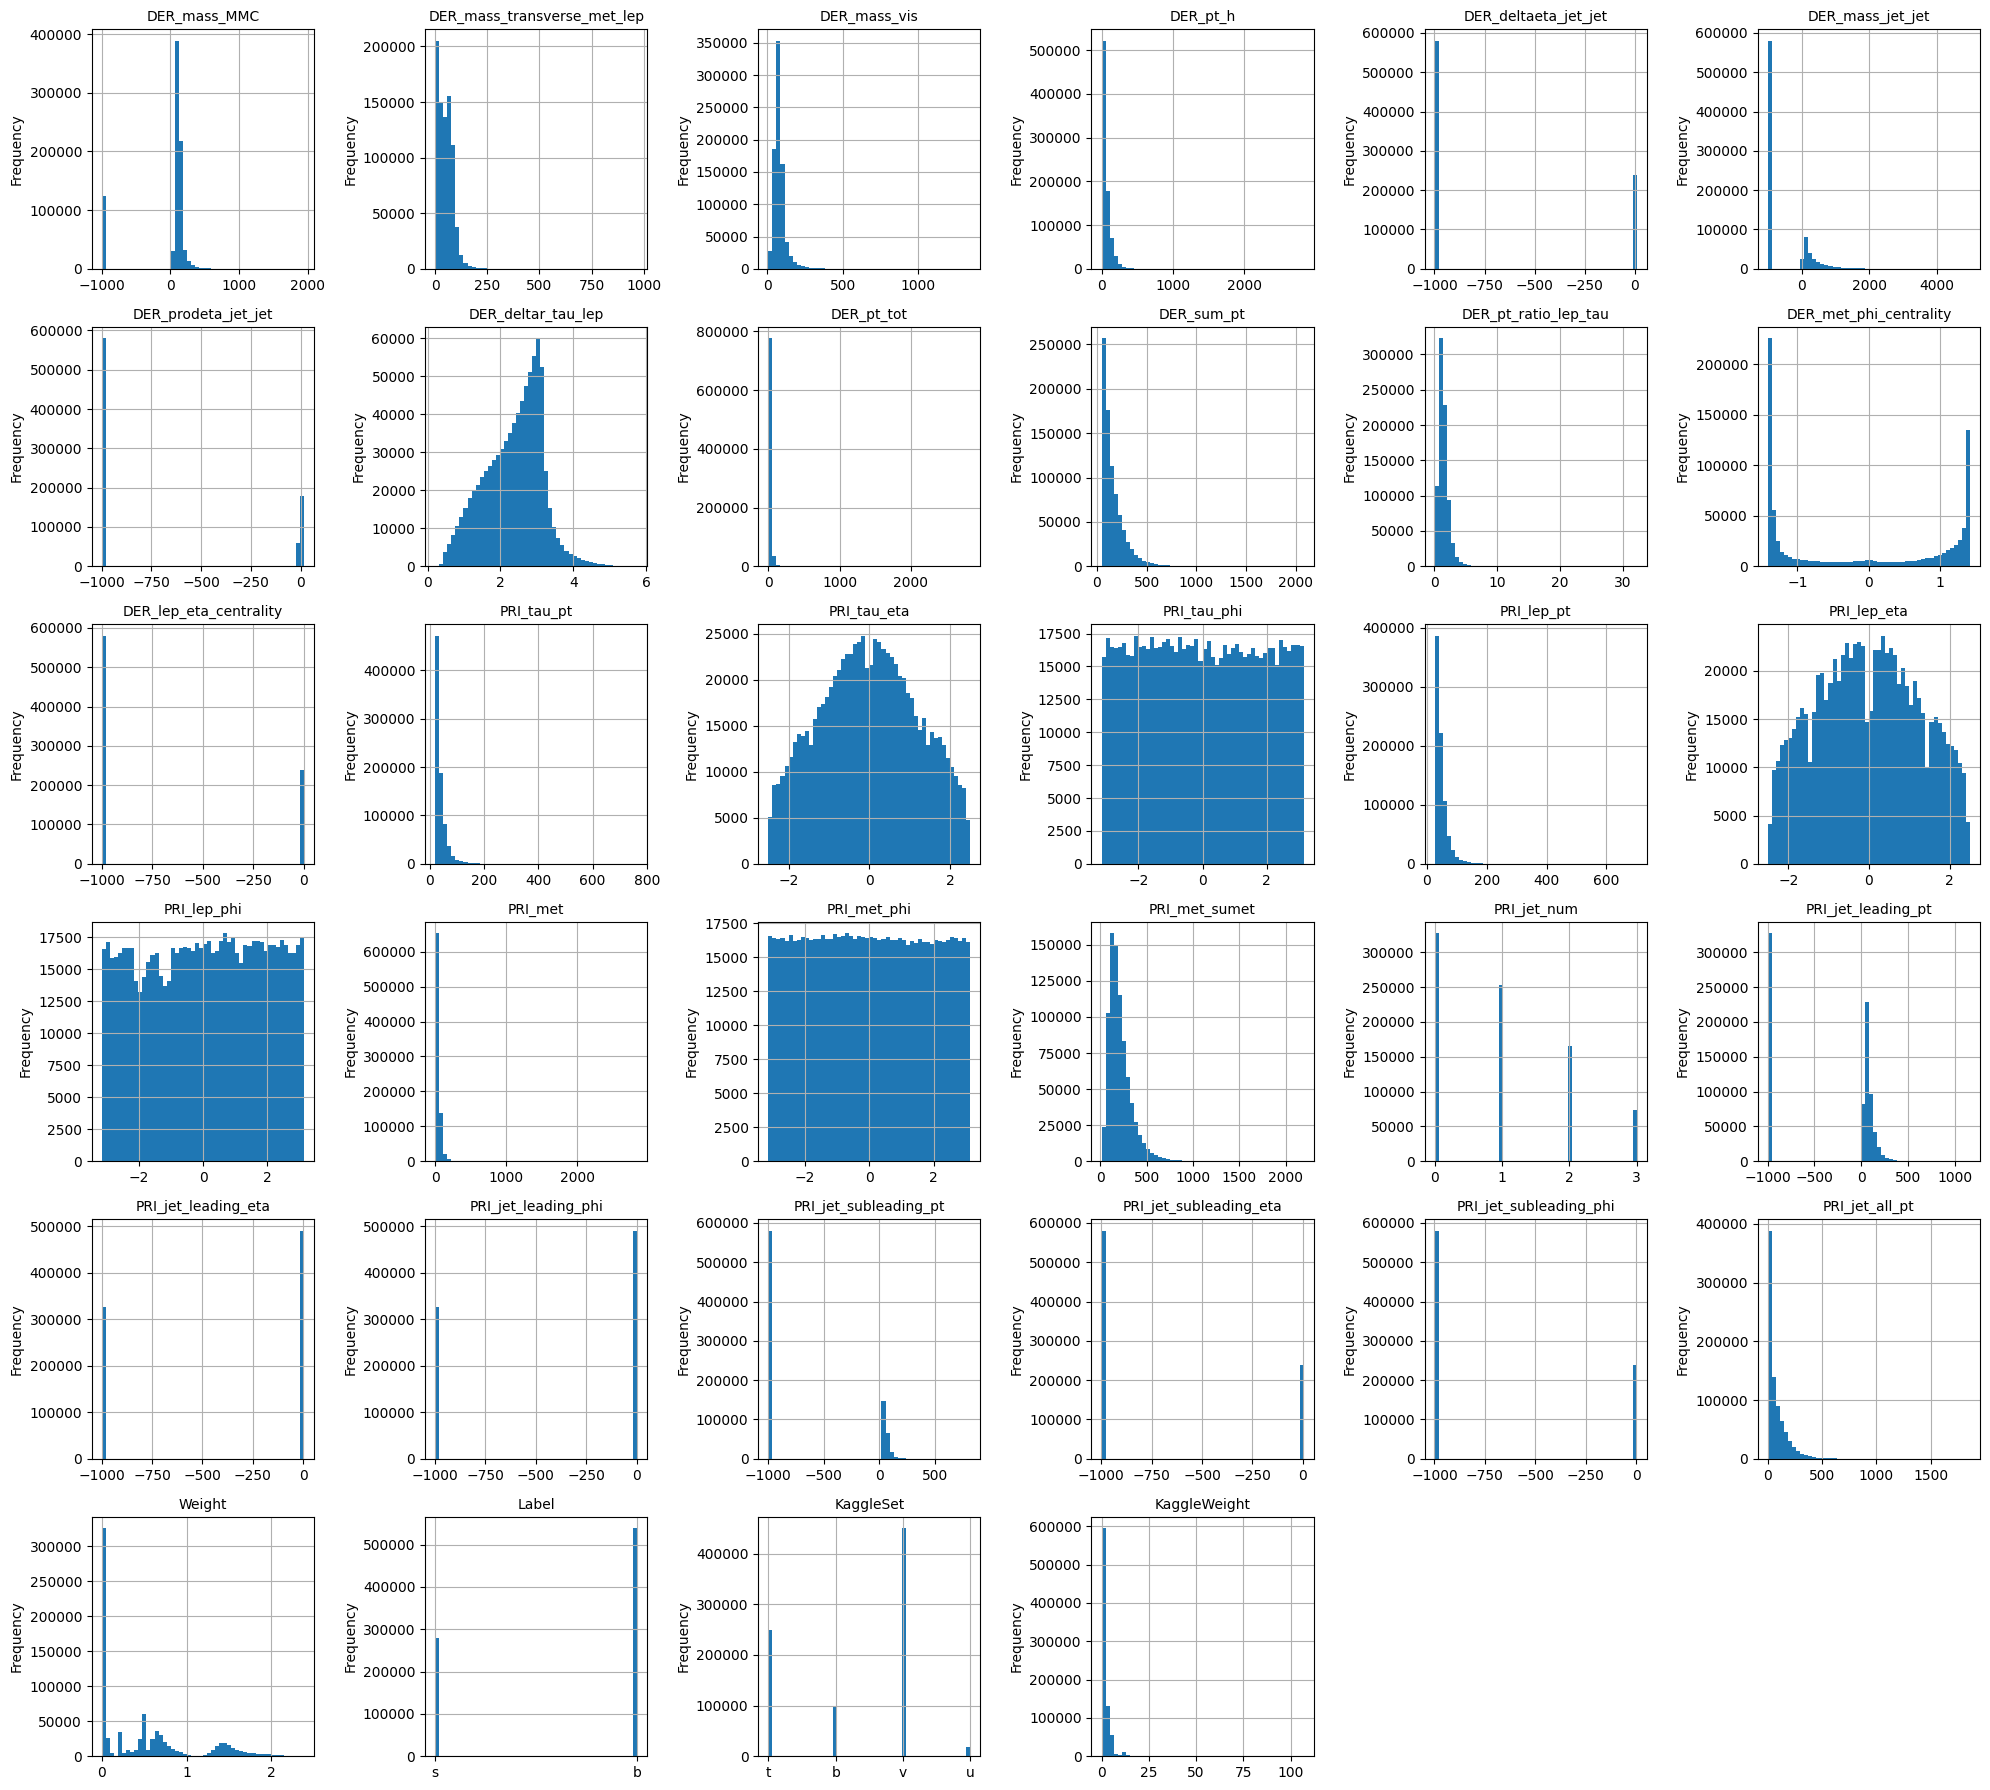

In [3]:
plt.figure(figsize=(20, 18))

for i, column in enumerate(df.columns):
    plt.subplot(6, 6, i + 1)
    df[column].hist(bins=50)
    plt.title(column, fontsize=10)
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("../plots/histogram_nonclean.png", dpi=300)
plt.show()

## Treatment of Missing Values
- Missing data can bias parameter estimation and weaken predictive reliability.
- Since the dataset is large and missingness is minimal, we apply *listwise deletion* (drop rows with NaN). This preserves consistency while simplifying the model.
- In Bayesian modeling, missing values could alternatively be imputed as latent variables, but given the data size, deletion is more practical here.

In [4]:
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100
# Print columns with missing values and their percentages
for col, perc in missing_values_percentage.items():
    if perc > 0:
        print(f"Column: {col}, Missing Values: {perc:.2f}%")
# Drop rows with any missing values
df = df.dropna()

## Treatment of Incoherent or Incorrect Values
- We realized that there were many -999 values for many variables. The missing values in columns with 'jet' in their name are from particles with 'PRI_jet_num' equal to 0 or 1, so instead of dropping the rows we will drop the columns. They only give information about particles with 2 or 3 jets and otherwise we would miss 71% of our data. 
- There is another column, DER_mass_MCC with 15.23% of missing values. In this case we prefer to delete those rows since the variable is important and we don't want to lose it, and 15.23% of the data is an acceptable price to keep it.

In [5]:
# A value is missing if it is equal to -999.0
df.replace(-999.0, np.nan, inplace=True)
# Count number of missing values per column
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100
# Print columns with missing values and their percentages
for col, perc in missing_values_percentage.items():
    if perc > 0:
        print(f"Column: {col}, Missing Values: {perc:.2f}%")

Column: DER_mass_MMC, Missing Values: 15.23%
Column: DER_deltaeta_jet_jet, Missing Values: 70.91%
Column: DER_mass_jet_jet, Missing Values: 70.91%
Column: DER_prodeta_jet_jet, Missing Values: 70.91%
Column: DER_lep_eta_centrality, Missing Values: 70.91%
Column: PRI_jet_leading_pt, Missing Values: 40.01%
Column: PRI_jet_leading_eta, Missing Values: 40.01%
Column: PRI_jet_leading_phi, Missing Values: 40.01%
Column: PRI_jet_subleading_pt, Missing Values: 70.91%
Column: PRI_jet_subleading_eta, Missing Values: 70.91%
Column: PRI_jet_subleading_phi, Missing Values: 70.91%


In [6]:
# Drop columns with NA except DER_mass_MMC
cols_to_drop = [col for col in missing_values.index if missing_values[col] > 0 and col != "DER_mass_MMC"]
df.drop(columns=cols_to_drop, inplace=True)

# Drop rows with any missing values in DER_mass_MMC
df.dropna(subset=["DER_mass_MMC"], inplace=True)
df = df.dropna()
df.reset_index(drop=True, inplace=True)

## Elimination of Irrelevant Variables
- Two variables related to the kaggle competition that used this dataset are irrelevant to the model.
- Weight is separated from features

In [7]:
# Drop uninformative columns
weights = df["Weight"]
df = df.drop(["KaggleSet", "KaggleWeight", "Weight"], axis=1)


## Elimination of Redundant Variables
- Highly correlated variables can cause multicollinearity and slow down Bayesian sampling.
- We detect features with |correlation| > 0.85 and drop one of each pair.
- This approximates a decorrelated feature space while preserving interpretability.

In [8]:
corr_matrix = df.drop(columns=["Label"]).corr().abs()

# Keep only the upper triangle of the correlation matrix (to avoid duplicates)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns to drop
to_drop = []
drop_reasons = []

for column in upper.columns:
    # Find correlations above threshold
    high_corr = upper[column][upper[column] > 0.85]
    if not high_corr.empty:
        to_drop.append(column)
        for correlated_col, corr_value in high_corr.items():
            drop_reasons.append((column, correlated_col, corr_value))

# Drop the columns
df.drop(columns=to_drop, inplace=True)

# Print results
print(f"Dropped {len(to_drop)} highly correlated (redundant) features:\n")
for col, corr_col, corr_val in drop_reasons:
    print(f" - Dropped '{col}' (correlated with '{corr_col}' at {corr_val:.2f})")

Dropped 3 highly correlated (redundant) features:

 - Dropped 'DER_mass_vis' (correlated with 'DER_mass_MMC' at 0.91)
 - Dropped 'PRI_met_sumet' (correlated with 'DER_sum_pt' at 0.91)
 - Dropped 'PRI_jet_all_pt' (correlated with 'DER_sum_pt' at 0.97)
 - Dropped 'PRI_jet_all_pt' (correlated with 'PRI_met_sumet' at 0.89)


## Coding of Non-Continuous Variables
- The categorical variable `PRI_jet_num` represents the number of jets (0, 1, 2 or 3).
- Even though it is technically discrete, its numeric values have an inherent ordering. Treating PRI_jet_num as numeric implicitly assumes the log-odds of being signal changes monotonically with jet count. For this variable, such a monotonic relationship is theoretically justified: in the Higgs signal process, certain jet multiplicities are systematically more (or less) likely to occur. If the actual relationship is nonlinear, it can be captured via Bayesian priors that allow smooth deviations.

## Normalization of Variables
- Standardization (zero mean, unit variance) ensures comparable scales for all features.
- In Bayesian logistic regression, this stabilizes posterior sampling since priors like Normal(0, 2.5) assume standardized covariates.
- It also mitigates numerical instability in matrix operations during MCMC.

In [9]:
scaler = StandardScaler()
num_features = df.select_dtypes(include=[np.number]).columns
df[num_features] = scaler.fit_transform(df[num_features])
print("Standardized all numeric features.")

Standardized all numeric features.


## Labels from "b" and "s" to 0 and 1

In [10]:
df['Label'] = df['Label'].map({'b': 1, 's': 0}).astype(int)

# Visualize data distributions

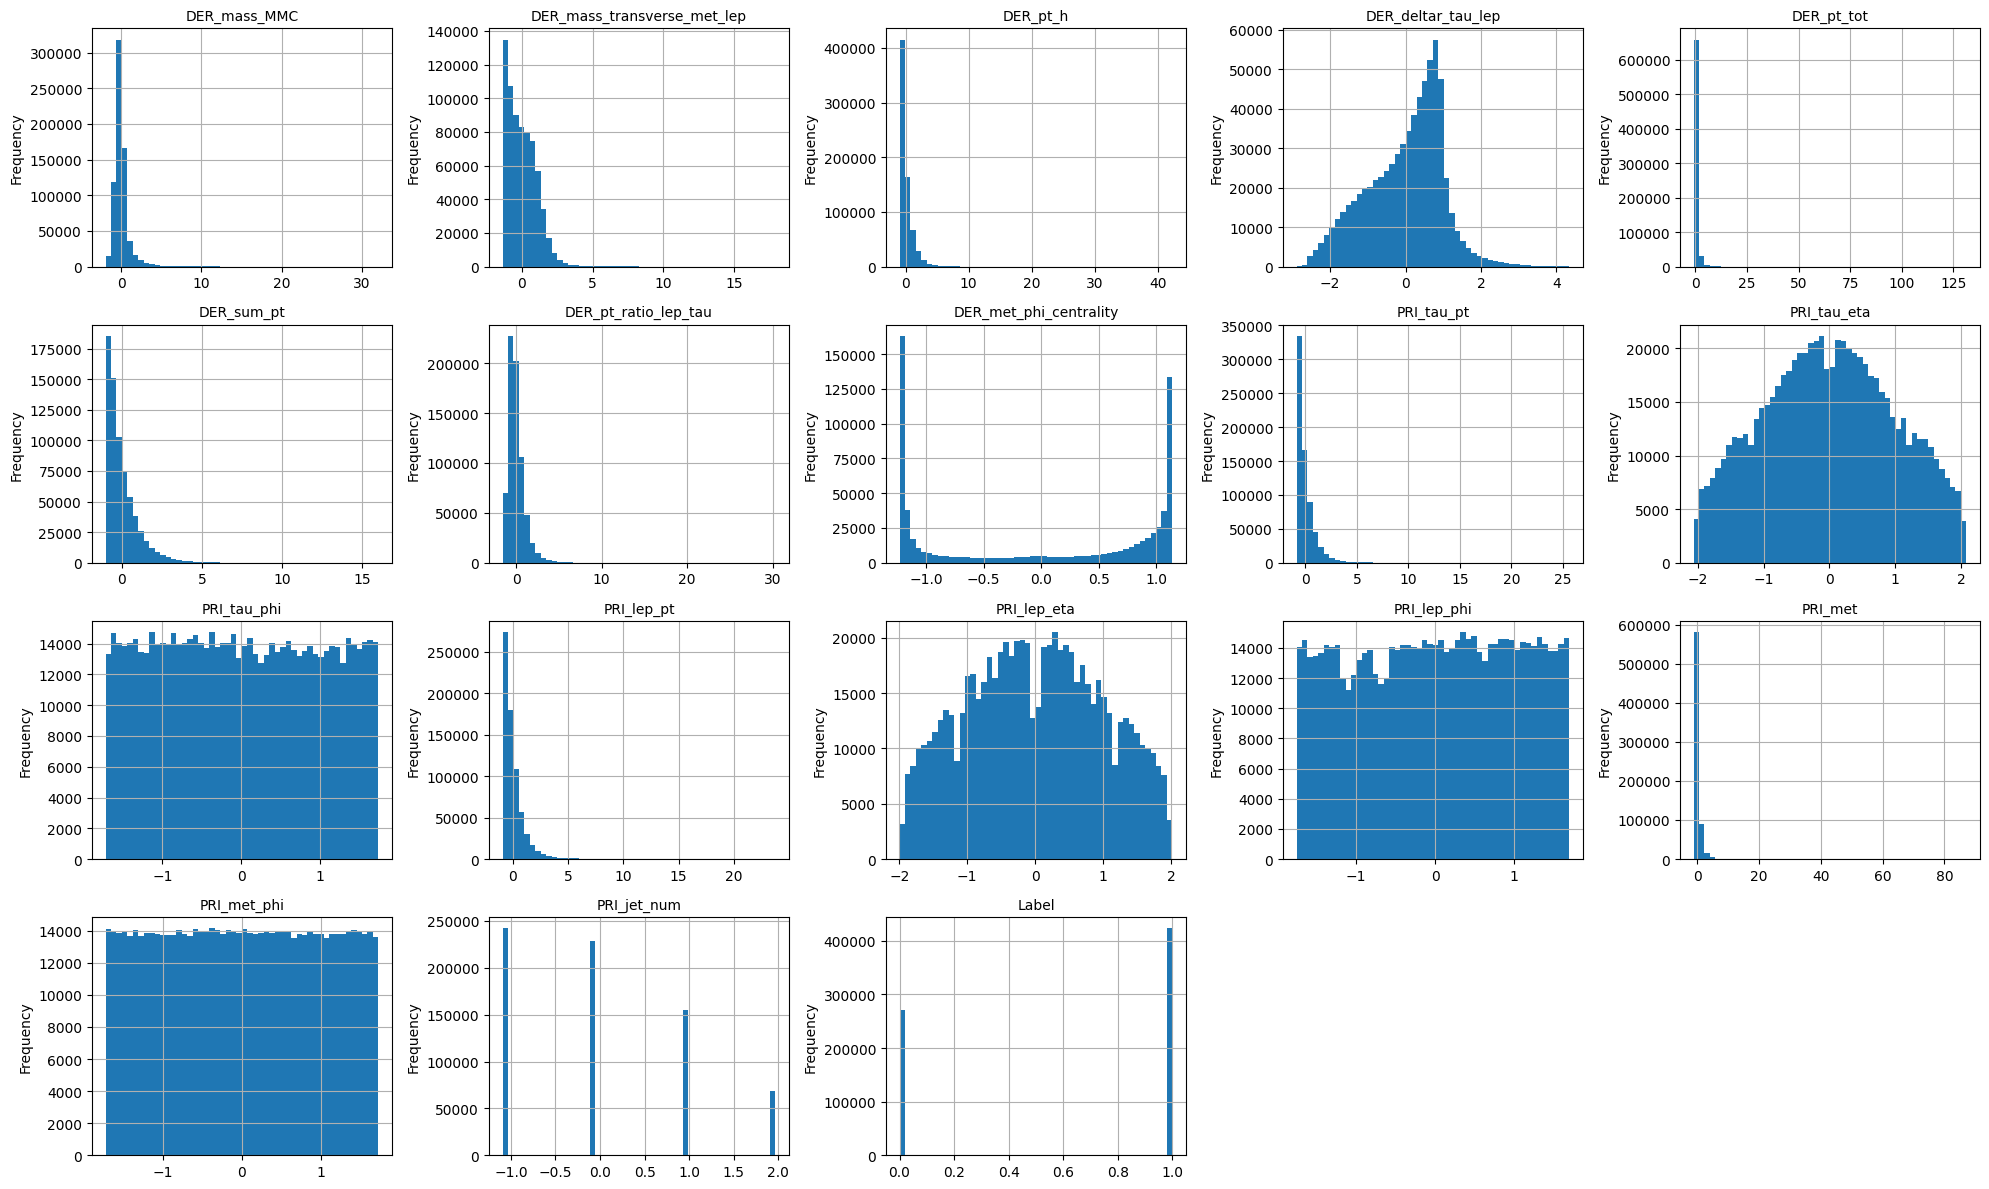

In [12]:
plt.figure(figsize=(20, 12))

for i, column in enumerate(df.columns):
    plt.subplot(4, 5, i + 1)
    df[column].hist(bins=50)
    plt.title(column, fontsize=10)
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("../plots/histogram.png", dpi=300)
plt.show()

In [13]:
#Save dataset and weights
df.to_csv("../data/processed/df_preprocessed.csv")
weights.to_csv("../data/processed/weights.csv")